In [1]:
%load_ext autoreload
%matplotlib inline

In [2]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import time
import os
import math
from IPython.display import display, clear_output
import helpfunction as helper

pd.set_option('display.max_columns', 500)

In [3]:
%autoreload

In [4]:
gr = (1 + 5 ** 0.5) / 2
outdir= './output/NuMuCC/'
run = 'Run1'
inputdir = './input/v16/'+run.lower()+'/' 
main_tree_name= 'pandoraSliceId'

In [5]:
muon_candidate_selection = "track_score>0.8 &\
                            vtx_distance<4 &\
                            track_chi2_proton>60 &\
                            track_chi2_muon<30 &\
                            (track_chi2_proton/track_chi2_muon)>7 &\
                            track_length>5"

event_selection = 'nu_pdg==14 &\
                   (flashMatchScore<10 | topologicalScore>0.25) &\
                   all_start_contained &\
                   nu_vtx_fiducial &\
                   longest_muon_candidate_length==track_length &\
                   topologicalScore>0.06 &\
                   (flashMatchScore/bestCosmicMatch)<5'

In [6]:
dict_names = ['nue','nu','on','off', 'dirt']

fidvol_vtx = [10,10,10,10,10,50] 
fidvol_end = [10,10,10,10,10,10]

lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]

mass_mu = 0.106
kin_min = 0.02
kin_min_mu = kin_min + mass_mu

In [7]:
pot_on = 3.83e+19

if 0:
    triggers_off = 18141621
    triggers_on = 9872165
    pot_nue = 3.795e+22
    pot_nu = 6.992e+19
    pot_dirt = 1.004e+20

    scale_off = triggers_on / triggers_off
    scale_nu = pot_on / pot_nu
    scale_nue = pot_on / pot_nue
    scale_on = 1
    scale_dirt = pot_on / pot_dirt

    #['nue','nu','on','off', 'dirt'] 
    scales = [scale_nue, scale_nu, scale_on, scale_off, scale_dirt]
    
else:
    # run1
    scales= [0.001543614833101641/0.8, 0.2713110044947349/0.75, 1, 0.2518141181293814, 0.38888655762260044/0.75]
    # run3
    #scales = [0.0007192342269585753/0.8, 0.06690072030802283/0.75, 1, 0.22691151836381887, 0.08163571601268166/0.75]

print(scales)

title_str = "MicroBooNE {0:.2g} POT, INTERNAL".format(pot_on)

[0.0019295185413770513, 0.36174800599297985, 1, 0.2518141181293814, 0.5185154101634672]


In [8]:
def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)
    
def inTPC_mask(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    mask = inTPC_mask(df, str_x, str_y, str_z, fidvol)
    return df[mask]

def cosmic_angles(mom_x, mom_y, mom_z,df_out=True):
    theta_beam = np.arctan2(np.sqrt(np.square(mom_x)+np.square(mom_y)),mom_z)
    phi_beam = np.arctan2(mom_y,mom_x)
    if df_out:
        return pd.DataFrame({'theta':theta_beam, 'phi':phi_beam})[['theta','phi']]
    else:
        return np.array([theta_beam, phi_beam])
    
def mc_track_contained(x_s,y_s,z_s,p_x,p_y,p_z,length):
    l_n = length/np.sqrt(p_x**2+p_y**2+p_z**2)
    x_e = x_s + p_x*l_n
    y_e = y_s + p_y*l_n
    z_e = z_s + p_z*l_n
    df_end = pd.DataFrame({'x_e':x_e, 'y_e':y_e, 'z_e':z_e})
    return inTPC_mask(df_end, 'x_e', 'y_e', 'z_e')

In [9]:
file_dict = {}
tree_names = ['']

flist =  os.listdir(inputdir)
for sample,scale in zip(dict_names, scales):
    file_name = next((s for s in flist if "NuCC_"+sample+"_" in s), None)
    file_dict[sample] = {}
    file_dict[sample]["all_events"] = uproot.open(inputdir+file_name)[main_tree_name+'/events']
    file_dict[sample]["slices"] = uproot.open(inputdir+file_name)[main_tree_name+'/slices']
    file_dict[sample]["events"] = uproot.open(inputdir+file_name)['nuCCAnalyser/Event']
    file_dict[sample]["daughters"] = uproot.open(inputdir+file_name)['nuCCAnalyser/Daughters']

    print(sample+":\tAll events: ", file_dict[sample]["all_events"].numentries, end="")
    print("\tSelected events: ", file_dict[sample]["events"].numentries, end="")
    print("\tScaled to data: ", round(file_dict[sample]["events"].numentries*scale))

nue:	All events:  42015	Selected events:  33599	Scaled to data:  65
nu:	All events:  112250	Selected events:  48443	Scaled to data:  17524
on:	All events:  152619	Selected events:  34223	Scaled to data:  34223
off:	All events:  427928	Selected events:  59133	Scaled to data:  14891
dirt:	All events:  32296	Selected events:  7324	Scaled to data:  3798


In [10]:
sample = "nu"
for name in file_dict[sample]:
    print('\n*** ', name, ' ***')
    print([c.decode('UTF-8') for c in file_dict[sample][name].keys()])


***  slices  ***
['sliceId', 'run', 'subRun', 'event', 'evt_time_sec', 'evt_time_nsec', 'hasDeposition', 'totalCharge', 'centerX', 'centerY', 'centerZ', 'minCRTdist', 'CRTtime', 'CRTplane', 'CRTtracklength', 'CRTnumtracks', 'deltaY', 'deltaZ', 'deltaYSigma', 'deltaZSigma', 'chargeToLightRatio', 'xclVariable', 'passesPreCuts', 'flashMatchScore', 'totalPEHypothesis', 'peHypothesisSpectrum', 'isTaggedAsTarget', 'targetMethod', 'isConsideredByFlashId', 'topologicalScore', 'hasBestTopologicalScore', 'hasBestFlashMatchScore', 'nHits', 'maxDeltaLLMCS', 'lengthDeltaLLMCS', 'stoppingMuTagMichel', 'stoppingMuTagBragg', 'ct_result_michel_plane0', 'ct_result_michel_plane1', 'ct_result_michel_plane2', 'ct_result_bragg_plane0', 'ct_result_bragg_plane1', 'ct_result_bragg_plane2', 'dqds_michelalg_percdiff_plane0', 'dqds_michelalg_percdiff_plane1', 'dqds_michelalg_percdiff_plane2', 'dqds_braggalg_percdiff_plane0', 'dqds_braggalg_percdiff_plane1', 'dqds_braggalg_percdiff_plane2', 'bragg_local_lin_plane

In [11]:
a = file_dict["nu"]["daughters"].pandas.df(['mc_vx', 'mc_vy', 'mc_vz', 'mc_px', 'mc_py', 'mc_pz', 'mc_length'])
nu_daughters_contained = mc_track_contained(*a.values.T)
mc_hit_fraction = file_dict["nu"]["daughters"].array("mc_hit_fraction")

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in sqrt
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


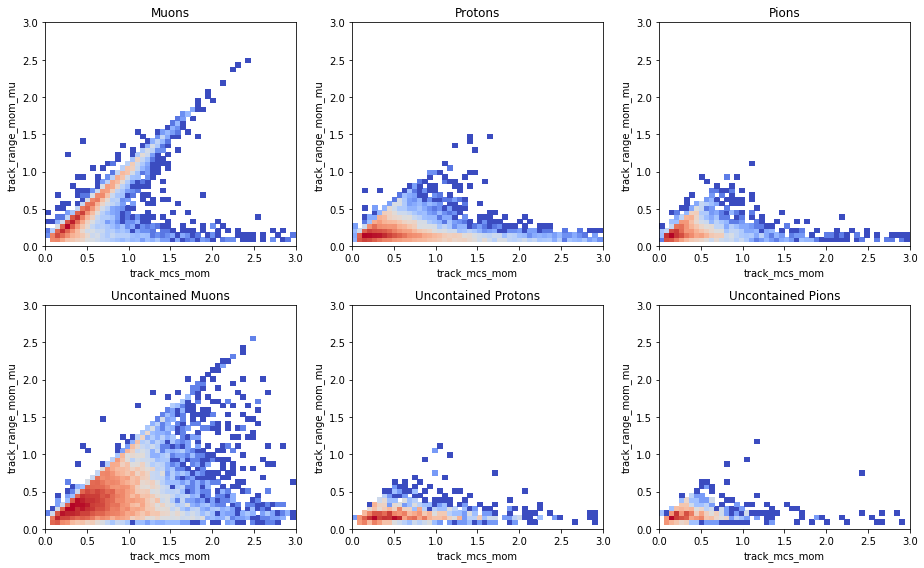

In [12]:
neutrino = (file_dict["nu"]["daughters"].array("mc_hit_fraction")>0.5) & (file_dict["nu"]["daughters"].array("track_length")>5) 
muons = (file_dict["nu"]["daughters"].array("mc_pdg")==13) & neutrino & nu_daughters_contained
protons = (file_dict["nu"]["daughters"].array("mc_pdg")==2212) & neutrino & nu_daughters_contained
pions = (file_dict["nu"]["daughters"].array("mc_pdg")==211) & neutrino & nu_daughters_contained
un_muons = (file_dict["nu"]["daughters"].array("mc_pdg")==13) & neutrino & ~nu_daughters_contained
un_protons = (file_dict["nu"]["daughters"].array("mc_pdg")==2212) & neutrino & ~nu_daughters_contained
un_pions = (file_dict["nu"]["daughters"].array("mc_pdg")==211) & neutrino & ~nu_daughters_contained

data8 = [ file_dict["nu"]["daughters"].array("track_range_mom_mu")[muons],
          file_dict["nu"]["daughters"].array("track_range_mom_mu")[protons],
          file_dict["nu"]["daughters"].array("track_range_mom_mu")[pions],
          file_dict["nu"]["daughters"].array("track_range_mom_mu")[un_muons],
          file_dict["nu"]["daughters"].array("track_range_mom_mu")[un_protons],
          file_dict["nu"]["daughters"].array("track_range_mom_mu")[un_pions],
       ]

data9 = [ file_dict["nu"]["daughters"].array("track_mcs_mom")[muons],
          file_dict["nu"]["daughters"].array("track_mcs_mom")[protons],
          file_dict["nu"]["daughters"].array("track_mcs_mom")[pions],
          file_dict["nu"]["daughters"].array("track_mcs_mom")[un_muons],
          file_dict["nu"]["daughters"].array("track_mcs_mom")[un_protons],
          file_dict["nu"]["daughters"].array("track_mcs_mom")[un_pions]
       ]


fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(8*gr,8))
ax=ax.flatten()
for i,l in enumerate(['Muons', 'Protons', 'Pions', 'Uncontained Muons', 'Uncontained Protons', 'Uncontained Pions']):
    ax[i].hist2d(data9[i], data8[i], bins=50, range=((0,3),(0,3)), cmap='coolwarm', norm=LogNorm())
    ax[i].set_xlabel('track_mcs_mom')
    ax[i].set_ylabel('track_range_mom_mu')
    ax[i].set_title(l)

fig.tight_layout()
fig.show()
fig.savefig(outdir+'muon_canidate33.pdf')

In [13]:
df = file_dict["nu"]["daughters"].pandas.df()

In [14]:
file_dict["nu"]["all_events"].array('nuMode')

array([10,  0,  1, ..., 10,  1,  2], dtype=int32)

In [15]:
df.head(10)

,event,run,subrun,evt_time_sec,evt_time_nsec,hitsU,hitsV,hitsY,caloU,caloV,caloY,hitsSps,generation,track_score,is_shower,is_track,has_shower_daughter,is_track_daughter,vx,vy,vz,vtx_distance,track_length,track_endx,track_endy,track_endz,track_dirx,track_diry,track_dirz,track_range_mom_p,track_range_mom_mu,track_mcs_mom,track_mcs_err,track_mcs_ll,track_chi2_proton,track_chi2_muon,shower_length,shower_openangle,shower_dirx,shower_diry,shower_dirz,start_dedxU,start_dedxV,start_dedxY,start_hitsU,start_hitsV,start_hitsY,start_pitchU,start_pitchV,start_pitchY,mc_neutrino,mc_pdg,mc_hit_fraction,mc_vx,mc_vy,mc_vz,mc_vx_sce,mc_vy_sce,mc_vz_sce,mc_length,mc_energy,mc_px,mc_py,mc_pz
0,825,5779,16,1459897070,616388000,213,658,558,0.581706,0.472603,0.528298,1345,2,1.000000,False,True,False,False,255.721130,-43.198341,474.061035,4.051679,223.668991,238.675018,106.629845,637.752991,-0.045058,0.364467,0.930125,1.438374,0.610066,0.566998,0.009,119.248749,190.531113,6.814707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0,0,0,0.000000,0.000000e+00,0.000000,True,13,0.969209,257.039673,-76.993759,440.204803,258.786194,-69.987564,440.332886,319.393799,0.868490,-0.046928,0.519771,0.686110
1,849,5779,16,1459897115,280474000,274,402,588,0.707104,0.770010,1.301676,1129,2,0.008332,True,False,False,False,117.512039,28.856026,984.799988,0.990124,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.438374,0.610066,0.566998,0.009,119.248749,190.531113,6.814707,81.196991,0.353768,-0.057806,0.194764,0.979145,0.689831,7.940670e+00,7.635530,2,14,13,0.934864,4.557588e-01,0.306390,True,11,0.954114,115.872162,29.669846,984.750793,117.567322,28.830555,983.608459,34.675415,2.867212,-0.162827,0.509499,2.816878
2,849,5779,16,1459897115,280474000,113,65,59,0.156526,0.150488,0.180273,224,2,0.960199,False,True,False,False,117.911201,27.072613,984.684509,1.876057,38.149067,127.465919,-5.565117,1001.883850,0.237042,-0.890971,0.387275,0.734241,0.196783,0.284000,0.096,16.839083,14.349820,75.472038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0,0,0,0.000000,0.000000e+00,0.000000,True,2212,0.966245,115.872162,29.669846,984.750793,117.567322,28.830555,983.608459,40.626808,1.197725,0.144272,-0.661521,0.309461
3,858,5779,17,1459897127,948878000,219,57,30,0.201373,0.067596,0.109667,146,2,0.898738,False,True,False,False,23.073599,-42.125011,403.377899,5.758258,29.350573,35.486233,-68.678658,404.269287,0.434941,-0.895597,0.093445,0.674138,0.173466,0.314000,0.156,10.562411,368.992737,41.967426,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0,0,0,0.000000,0.000000e+00,0.000000,True,13,0.980392,84.754570,-147.810852,391.054565,85.799110,-147.810852,391.054565,138.038986,0.442632,-0.258584,0.336721,0.067178
4,871,5779,17,1459897158,614308000,389,589,275,0.431671,0.385910,0.450215,1117,2,1.000000,False,True,False,False,250.969452,-67.731491,450.377502,0.537707,196.655746,219.044678,107.227600,529.967102,-0.291430,0.740987,0.604985,1.357999,0.550839,0.518997,0.020,93.172371,232.931870,17.659492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0,0,0,0.000000,0.000000e+00,0.000000,False,13,0.980392,84.754570,-147.810852,391.054565,85.799110,-147.810852,391.054565,138.038986,0.442632,-0.258584,0.336721,0.067178
5,894,5779,17,1459897213,950206000,319,284,616,0.443040,0.461672,0.432811,1177,2,1.000000,False,True,False,False,93.792183,-15.548796,456.246826,33.005375,182.658890,76.099304,-27.739595,637.149292,0.034478,-0.067220,0.997142,1.314873,0.520272,0.517997,0.040,73.925835,95.820419,4.268423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0,0,0,0.000000,0.000000e+00,0.000000,True,13,0.967186,89.746330,-17.651812,458.202209,93.995430,-17.388103,458.116089,180.958725,0.528571,0.001649,-0.040159,0.516341
6,894,5779,17,1459897213,950206000,66,35,25,0.046033,0.048486,0.041673,119,2,0.610613,False,True,True,False,94.379677,15.061990,443.305

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


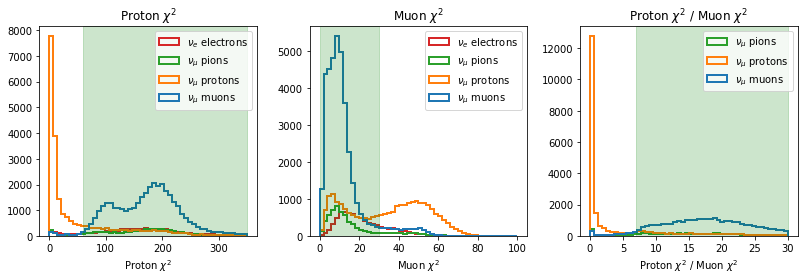

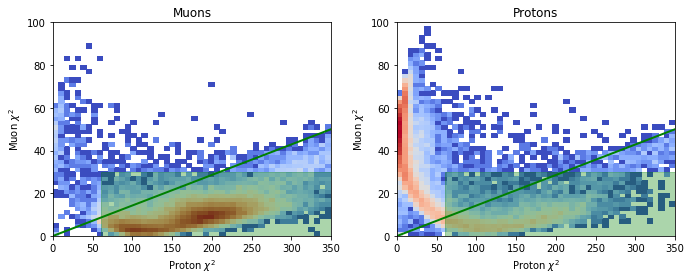

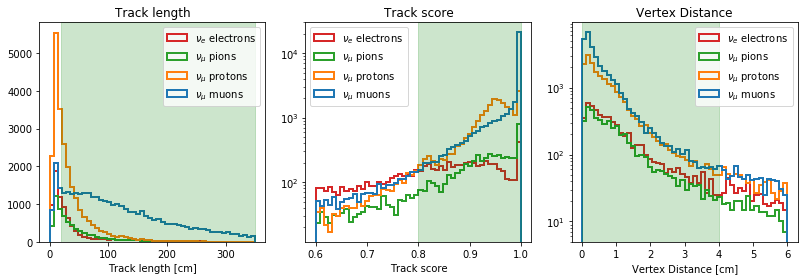

In [16]:
neutrino = (file_dict["nu"]["daughters"].array("mc_hit_fraction")>0.5) & (file_dict["nu"]["daughters"].array("track_length")>5)
muons = (file_dict["nu"]["daughters"].array("mc_pdg")==13) & neutrino
protons = (file_dict["nu"]["daughters"].array("mc_pdg")==2212) & neutrino
pions = (file_dict["nu"]["daughters"].array("mc_pdg")==211) & neutrino

neutrino = (file_dict["nue"]["daughters"].array("mc_hit_fraction")>0.5) & (file_dict["nue"]["daughters"].array("track_length")>5)
electrons = (file_dict["nue"]["daughters"].array("mc_pdg")==11) & neutrino


data1 = [ file_dict["nu"]["daughters"].array("track_chi2_proton")[muons],
          file_dict["nu"]["daughters"].array("track_chi2_proton")[protons],
          file_dict["nu"]["daughters"].array("track_chi2_proton")[pions],
          file_dict["nue"]["daughters"].array("track_chi2_proton")[electrons]
       ]
data2 = [file_dict["nu"]["daughters"].array("track_chi2_muon")[muons],
         file_dict["nu"]["daughters"].array("track_chi2_muon")[protons],
         file_dict["nu"]["daughters"].array("track_chi2_muon")[pions],
         file_dict["nue"]["daughters"].array("track_chi2_muon")[electrons]
       ]
data3 = [file_dict["nu"]["daughters"].array("track_length")[muons],
         file_dict["nu"]["daughters"].array("track_length")[protons],
         file_dict["nu"]["daughters"].array("track_length")[pions],
         file_dict["nue"]["daughters"].array("track_length")[electrons]
       ]
data4 = [file_dict["nu"]["daughters"].array("track_score")[muons],
         file_dict["nu"]["daughters"].array("track_score")[protons],
         file_dict["nu"]["daughters"].array("track_score")[pions],
         file_dict["nue"]["daughters"].array("track_score")[electrons]
       ]

data5 = [data1[0]/data2[0], data1[1]/data2[1], data1[2]/data2[2]]

data6 = [file_dict["nu"]["daughters"].array("vtx_distance")[muons],
         file_dict["nu"]["daughters"].array("vtx_distance")[protons],
        file_dict["nu"]["daughters"].array("vtx_distance")[pions],
         file_dict["nue"]["daughters"].array("vtx_distance")[electrons]
       ]

labs = [r'$\nu_\mu$ muons', r'$\nu_\mu$ protons', r'$\nu_\mu$ pions', r'$\nu_e$ electrons']

fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4))
ax[0].hist(data1, label=labs, range=(0,350), histtype='step', bins=50, lw=2)
ax[0].axvspan(60, 350, alpha=0.2, color="green")
ax[0].legend()
ax[0].set_xlabel(r'Proton $\chi^2$')
ax[0].set_title('Proton $\chi^2$')
ax[1].hist(data2, label=labs, range=(0,100), histtype='step', bins=50, lw=2)
ax[1].axvspan(0, 30, alpha=0.2, color="green")
ax[1].legend()
ax[1].set_xlabel(r'Muon $\chi^2$')
ax[1].set_title('Muon $\chi^2$')
ax[2].hist(data5, label=labs, range=(0,30), histtype='step', bins=50, lw=2)
ax[2].axvspan(7, 30, alpha=0.2, color="green")
ax[2].set_xlabel(r'Proton $\chi^2$ / Muon $\chi^2$')
ax[2].set_title(r'Proton $\chi^2$ / Muon $\chi^2$')
ax[2].legend()
fig.tight_layout()
fig.show()
fig.savefig(outdir+'muon_candidate1.pdf')

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(6*gr,4))
ax[0].hist2d(data1[0], data2[0], bins=50, range=((0,350),(0,100)), cmap='coolwarm', norm=LogNorm())
ax[0].add_patch(patches.Rectangle( (60, 0), 290, 30, alpha=0.33, color='g'))
ax[0].plot(range(350), np.array(range(350))/7, color='g', lw=2)
ax[0].set_xlabel(r'Proton $\chi^2$')
ax[0].set_ylabel(r'Muon $\chi^2$')
ax[0].set_title('Muons')

ax[1].hist2d(data1[1], data2[1], bins=50, range=((0,350),(0,100)), cmap='coolwarm', norm=LogNorm())
ax[1].add_patch(patches.Rectangle( (60, 0), 290, 30, alpha=0.33, color='g'))
ax[1].plot(range(350), np.array(range(350))/7, color='g', lw=2)
ax[1].set_xlabel(r'Proton $\chi^2$')
ax[1].set_ylabel(r'Muon $\chi^2$')
ax[1].set_title('Protons')
fig.tight_layout()
fig.show()
fig.savefig(outdir+'muon_candidate2.pdf')


fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(7*gr,4))
ax[0].hist(data3, label=labs, range=(0,350), histtype='step', bins=50, lw=2)
ax[0].legend()
ax[0].set_xlabel(r'Track length [cm]')
ax[0].axvspan(20, 350, alpha=0.2, color="green")
ax[0].set_title('Track length')
ax[1].hist(data4, label=labs, range=(0.6,1), histtype='step', bins=50, lw=2)
ax[1].axvspan(0.8, 1, alpha=0.2, color="green")
ax[1].set_yscale('log')
ax[1].legend(loc=2)
ax[1].set_xlabel(r'Track score')
ax[1].set_title('Track score')
ax[2].hist(data6, label=labs, range=(0,6), histtype='step', bins=50, lw=2)
ax[2].axvspan(0, 4, alpha=0.2, color="green")
ax[2].set_xlabel(r'Vertex Distance [cm]')
ax[2].set_title(r'Vertex Distance')
ax[2].set_yscale('log')
ax[2].legend()
fig.tight_layout()
fig.show()
fig.savefig(outdir+'muon_candidate3.pdf')

In [17]:
df_daughters = [file_dict[sample]["daughters"].pandas.df() for sample in dict_names]

In [18]:
cols = ['evt_time_sec', 'evt_time_nsec',  
        'nuMode', 'nuX', 'nuW', 'nuPt', 'nuTheta', 'nuCCNC', 'nuEnergy', 
        'leptonEnergy', 'nuPdgCode', 'nuVertexX', 'nuVertexY', 'nuVertexZ']

df_nu_event = file_dict['nu']["all_events"].pandas.df(cols)
nu_tpc_mask = inTPC_mask( df_nu_event, 'nuVertexX', 'nuVertexY', 'nuVertexZ')
df_nu_event['mc_nu_fid_vol'] = inTPC_mask( df_nu_event, 'nuVertexX', 'nuVertexY', 'nuVertexZ', fidvol=fidvol_vtx)
nu_sig_mask = df_nu_event.eval('leptonEnergy>@kin_min_mu & nuCCNC==0 & abs(nuPdgCode)==14 & mc_nu_fid_vol')

#nu_pi0_mask = (file_dict['nu']["events"].array('mc_nu_daughter_pdg')==111).sum()==1
#df_nu_event[['theta_beam','phi_beam']] = cosmic_angles(*df_nu_event[['mc_nu_lepton_px', 'mc_nu_lepton_py', 'mc_nu_lepton_pz']].T.values)

In [19]:
# Add a bunch of stuff to the daughter frames to do the selection
for i,s in enumerate(dict_names):
    start = time.time()
    print(s)
    df_daughters[i]['hash'] = eventHash(df_daughters[i][['evt_time_sec', 'evt_time_nsec']])
    
    # do for all:
    start_mask = inTPC_mask(df_daughters[i], 'vx', 'vy', 'vz', fidvol_end)
    end_mask = inTPC_mask(df_daughters[i], 'track_endx', 'track_endy', 'track_endz', fidvol_end)
    df_daughters[i]['contained'] = start_mask & end_mask 
    df_daughters[i]['start_contained'] = start_mask
    df_daughters[i]['all_contained'] = df_daughters[i].groupby(['hash'])['contained'].transform(all)
    df_daughters[i]['all_start_contained'] = df_daughters[i].groupby(['hash'])['start_contained'].transform(all)
    
    # Add the pandora PDG code of the parent:
    df_event = file_dict[s]["events"].pandas.df(['evt_time_sec','evt_time_nsec','nu_pdg', 'caloY',
                                                 'num_tracks', 'num_showers', 'nu_vx', 'nu_vy', 'nu_vz'])
    df_event['hash'] = eventHash(df_event[['evt_time_sec', 'evt_time_nsec']])
    mapper = dict(zip(df_event['hash'],df_event['nu_pdg']))
    df_daughters[i]['nu_pdg'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],df_event['caloY']))
    df_daughters[i]['caloY'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],df_event['num_tracks']))
    df_daughters[i]['num_tracks'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],df_event['num_showers']))
    df_daughters[i]['num_showers'] = df_daughters[i]['hash'].map(mapper)
    
    reco_vtx_fid = inTPC_mask( df_event, 'nu_vx', 'nu_vy', 'nu_vz', fidvol=fidvol_vtx)
    mapper = dict(zip(df_event['hash'],reco_vtx_fid))
    df_daughters[i]['nu_vtx_fiducial'] = df_daughters[i]['hash'].map(mapper)
    
    df_all_event = file_dict[s]["all_events"].pandas.df(['evt_time_sec','evt_time_nsec','bestCosmicMatch'])
    df_all_event['hash'] = eventHash(df_all_event[['evt_time_sec', 'evt_time_nsec']])
    mapper = dict(zip(df_all_event['hash'],df_all_event['bestCosmicMatch']))
    df_daughters[i]['bestCosmicMatch'] = df_daughters[i]['hash'].map(mapper)
    
    # Add the topological score and the chi2
    if s in ['nu','nue']:
        df_slices = file_dict[s]["slices"].pandas.df(['evt_time_sec','evt_time_nsec','topologicalScore', 'flashMatchScore', 'isTaggedAsTarget', 'minCRTdist', 'purity','completeness'])
    else:
        df_slices = file_dict[s]["slices"].pandas.df(['evt_time_sec','evt_time_nsec','topologicalScore', 'flashMatchScore', 'isTaggedAsTarget', 'minCRTdist'])
    df_slices = df_slices.query('isTaggedAsTarget')
    df_slices['hash'] = eventHash(df_slices[['evt_time_sec', 'evt_time_nsec']])
    mapper = dict(zip(df_slices['hash'],df_slices['topologicalScore']))
    df_daughters[i]['topologicalScore'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_slices['hash'],df_slices['flashMatchScore']))
    df_daughters[i]['flashMatchScore'] = df_daughters[i]['hash'].map(mapper)
    mapper = dict(zip(df_slices['hash'],df_slices['minCRTdist']))
    df_daughters[i]['minCRTdist'] = df_daughters[i]['hash'].map(mapper)
    
    # there can be only one muon candidate per event!
    df_daughters[i]['muon_candidate'] = df_daughters[i].eval(muon_candidate_selection)
    df_daughters[i].loc[df_daughters[i]['muon_candidate'], 'longest_muon_candidate_length'] = df_daughters[i].query('muon_candidate').groupby(['hash'])['track_length'].transform(max)
    df_daughters[i].loc[~df_daughters[i]['muon_candidate'], 'longest_muon_candidate_length'] = -1

    #do for mc only 
    if s=='nu':
        mapper = dict(zip(df_all_event['hash'],nu_tpc_mask))
        df_daughters[i]['mc_nu_in_tpc'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_all_event['hash'],nu_sig_mask))
        
        df_daughters[i]['mc_nu_cc_sig'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],file_dict[s]["events"].array('mc_nu_lepton_energy')))
        df_daughters[i]['mc_nu_lepton_energy'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],file_dict[s]["events"].array('mc_nu_lepton_theta')))
        df_daughters[i]['mc_nu_lepton_theta'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_event['hash'],file_dict[s]["events"].array('mc_nu_vtx_distance')))
        df_daughters[i]['mc_nu_vtx_distance'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_all_event['hash'],file_dict["nu"]["all_events"].array('nuMode')))
        df_daughters[i]['mc_nu_mode'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_slices['hash'],df_slices['purity']))
        df_daughters[i]['purity'] = df_daughters[i]['hash'].map(mapper)
        mapper = dict(zip(df_slices['hash'],df_slices['completeness']))
        df_daughters[i]['completeness'] = df_daughters[i]['hash'].map(mapper)
        
    if s=='nue':
        mapper = dict(zip(df_event['hash'],file_dict[s]["events"].array('mc_nu_energy')))
        df_daughters[i]['mc_nu_energy'] = df_daughters[i]['hash'].map(mapper)

    end = time.time()
    print("Passed time: {0:0.1f}s".format(end - start))

nue
Passed time: 17.5s
nu
Passed time: 27.8s
on
Passed time: 20.6s
off
Passed time: 40.6s
dirt
Passed time: 4.4s


In [20]:
for i,s in enumerate(dict_names):
    df_daughters[i][['theta_beam','phi_beam']] = cosmic_angles(*df_daughters[i][['track_dirx', 'track_diry', 'track_dirz']].T.values)

/home/wouter/Binaries/miniconda3/envs/uprootenv/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


In [21]:
#### Selection queries
query_select_wo_trackcut = event_selection
query_select = query_select_wo_trackcut+' & track_length>20'
query_pure = "purity>0.5" # & abs(mc_pdg)==13" # & mc_nu_vtx_distance<5
query_event = query_select+' & '+query_pure

In [22]:
# how much nue events pass 
pot_nue = 2.481e+22
len(df_daughters[0].query('0.05 < mc_nu_energy & mc_nu_energy < 1.5').query(query_select))/pot_nue*13.2e20 

44.37243047158403

In [23]:
# Efficiency of CC inc
df_daughters[0] = df_daughters[1].query('mc_nu_cc_sig')
eff = len(df_daughters[0].query(query_select).query(query_pure))/sum(nu_sig_mask)*100
print(eff)

51.31096903958049


In [24]:
# Efficiency of CC pi0
#all_cc_pi0 = sum(nu_pi0_mask & nu_sig_mask)
#selected_cc_pi0 = len(df_daughters[0].query(query_select).query('mc_has_pi0'))
#print(selected_cc_pi0/all_cc_pi0*100)

In [25]:
# Selected hashes: 
selected_hashes = df_daughters[0].query(query_event)['hash']
df_daughters[0].query(query_select)['mc_pdg'].value_counts()/len(df_daughters[0].query(query_select))

 13      0.925671
 211     0.033655
 2212    0.022780
-13      0.007020
-211     0.005299
 2112    0.003992
 22      0.001170
 321     0.000206
 3222    0.000069
-321     0.000069
 0       0.000069
Name: mc_pdg, dtype: float64

0.9108217835643287

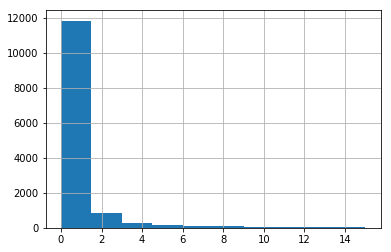

In [26]:
# Of the events I select, how much are actually reconstructed at the vertex
df_daughters[0].query(query_select)['mc_nu_vtx_distance'].hist(range=(0,15))
sum(df_daughters[0].query(query_select)['mc_nu_vtx_distance']<5)/len(selected_hashes)

In [27]:
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

[0.36174800599297985, 0.36174800599297985, 1, 0.2518141181293814, 0.5185154101634672, 0.36174800599297985]


In [28]:
# Purity
# on_contribution = df_daughters[2].query(query_event)*scales_here[2]
off_contribution = len(df_daughters[3].query(query_select))*scales_here[3]
nu_contribution = len(df_daughters[1].query(query_select))*scales_here[1]
dirt_contribution = len(df_daughters[4].query(query_select))*scales_here[4]

purity= len(df_daughters[0].query(query_select).query(query_pure))*scales_here[0] / (off_contribution+nu_contribution+dirt_contribution)
print(purity)

0.6642407805485655


In [29]:
df_nu_event.keys()

Index(['evt_time_sec', 'evt_time_nsec', 'nuMode', 'nuX', 'nuW', 'nuPt',
       'nuTheta', 'nuCCNC', 'nuEnergy', 'leptonEnergy', 'nuPdgCode',
       'nuVertexX', 'nuVertexY', 'nuVertexZ', 'mc_nu_fid_vol'],
      dtype='object')

In [30]:
## From now on we wil lalso put reco quality requirements on the 
df_daughters[0]=df_daughters[0].query(query_pure)

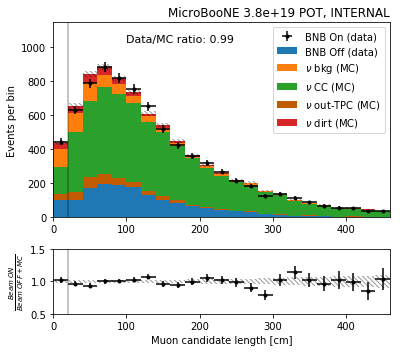

In [31]:
#track plot
fig,ax=plt.subplots(ncols=1,nrows=2,figsize=(3.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})

# Left
lab = 'Muon candidate length [cm]'
N=23
x_min = 0
x_max = 460
data = [df_daughters[i].query(query_select_wo_trackcut)['track_length'] for i,s in enumerate(dict_names)]
data[1] = df_daughters[1].query(query_select_wo_trackcut)['track_length']
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select_wo_trackcut).query('~mc_nu_in_tpc')['track_length'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))
ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0].set_ylabel('Events per bin')
ax[0].set_title(title_str, loc='right')
ax[0].set_ylim(0,1.3*max_val[2])
ax[0].text(100, ax[0].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
ax[0].set_xlim(x_min,x_max)
ax[0].axvline(x=20, color='k', alpha=0.3)
ax[0].legend()

# Ratio plots
ax[1].set_ylim(0.50,1.50)
ax[1].set_xlim(x_min,x_max)
ax[1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1].set_xlabel(lab)
ax[1].axvline(x=20, color='k', alpha=0.3)

fig.tight_layout()
fig.savefig(outdir+"numu_tracklength.pdf", bbox_inches="tight")

KeyError: 'mc_nu_lepton_energy'

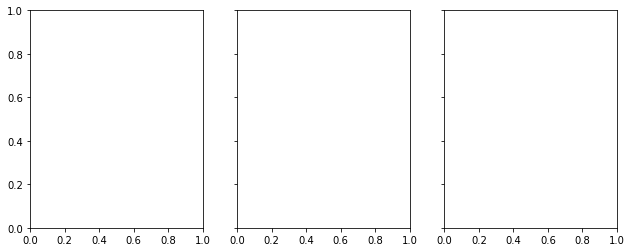

In [32]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(6.5*gr,4), sharey=True)

# Left
x_min = 0.125
x_max = 2.5
N = 19
denom = df_nu_event['mc_nu_lepton_energy'][nu_sig_mask]
nom = df_daughters[0].query(query_event)['mc_nu_lepton_energy']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'True lepton energy [GeV]')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')


# Middle
x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
x_min = 0
x_max = np.pi
N = 16
denom = df_nu_event['theta_beam'][nu_sig_mask]
nom =  df_nu_event[df_nu_event['hash'].isin(selected_hashes)]['theta_beam']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'True lepton theta')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[1].legend(loc='upper center')
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)

# Right
x_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
x_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$',r'$\pi/2$',r'$\pi$']
x_min = -np.pi
x_max = np.pi
N = 16
denom = df_nu_event['phi_beam'][nu_sig_mask]
nom =  df_nu_event[df_nu_event['hash'].isin(selected_hashes)]['phi_beam']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[2].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[2].set_xlabel(r'True lepton phi')
ax[2].set_ylim(0,1)
ax[2].set_xlim(x_min, x_max)
ax[2].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[2].legend(loc='upper center')
ax[2].set_xticks(x_ticks)
ax[2].set_xticklabels(x_labels)

fig.tight_layout()
fig.savefig(outdir+"eff.pdf", bbox_inches="tight")

In [ ]:
# Make plot ifo different modes
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(6.5,4))

# Left
x_min = 0.125
x_max = 2.5
N = 19

for mode,lab in zip(modes, labels):
denom = df_nu_event['mc_nu_lepton_energy'][nu_sig_mask]
nom = df_daughters[0].query(query_event)['mc_nu_lepton_energy']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'True lepton energy [GeV]')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')


In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})
scales= [0.001543614833101641/0.8, 0.2713110044947349/0.75, 1, 0.2518141181293814, 0.38888655762260044/0.75]
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

# Left
lab = 'Muon candidate phi'
x_ticks = [-np.pi, -np.pi/2, 0, np.pi/2, np.pi]
x_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$',r'$\pi/2$',r'$\pi$']
N=20
x_min = -np.pi
x_max = np.pi
data = [df_daughters[i].query(query_select)['phi_beam'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['phi_beam'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][0].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][0].set_ylabel('Events per bin')
ax[0][0].set_title(title_str, loc='right')
ax[0][0].set_ylim(0,1.3*max_val[2])
ax[0][0].set_xticks(x_ticks)
ax[0][0].set_xticklabels(x_labels)
ax[0][0].set_xlim(x_min,x_max)

# Ratio plots
ax[1][0].set_ylim(0.5,1.5)
ax[1][0].set_xlim(x_min,x_max)
ax[1][0].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].set_xlabel(lab)
ax[1][0].set_xticks(x_ticks)
ax[1][0].set_xticklabels(x_labels)

# Right
lab = 'Muon candidate theta'
x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']

N=20
x_min = 0
x_max = np.pi
data = [df_daughters[i].query(query_select)['theta_beam'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['theta_beam'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0][1].text(0.8, ax[0][1].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
ax[0][1].legend()
ax[0][1].set_ylabel('Events per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(0,1.5*max_val[2])
ax[0][1].set_xticks(x_ticks)
ax[0][1].set_xticklabels(x_labels)
ax[0][1].set_xlim(x_min,x_max)

# Ratio plots
ax[1][1].set_ylim(0.50,1.50)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_xlabel(lab)
ax[1][1].set_xticks(x_ticks)
ax[1][1].set_xticklabels(x_labels)

fig.tight_layout()
fig.savefig(outdir+"numu_phi_theta_0.pdf", bbox_inches="tight")

In [ ]:
fig,ax=plt.subplots(ncols=2,nrows=2,figsize=(6.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

# Left
lab = 'Track multiplicity'
N=6
x_min = 0.5
x_max = 6.5
data = [df_daughters[i].query(query_select)['num_tracks'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['num_tracks'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][0].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][0].set_ylabel('Events per bin')
ax[0][0].set_title(title_str, loc='right')
ax[0][0].set_ylim(0,1.3*max_val[2])
ax[0][0].set_xticks(range(7))
ax[0][0].set_xlim(x_min,x_max)

# Ratio plots
ax[1][0].set_ylim(0.5,1.5)
ax[1][0].set_xticks(range(7))
ax[1][0].set_xlim(x_min,x_max)
ax[1][0].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].set_xlabel(lab)



# Right
lab = 'Muon candidate momentum (MCS) [GeV]'
N=19
x_min = 0.1
x_max = 2.0
data = [df_daughters[i].query(query_select)['track_mcs_mom'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['track_mcs_mom'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0][1].legend()
ax[0][1].set_ylabel('Events per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(0,1.3*max_val[2])
ax[0][1].text(0.3, ax[0][1].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
ax[0][1].set_xlim(x_min,x_max)

# Ratio plots
ax[1][1].set_ylim(0.50,1.50)
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_xlabel(lab)

fig.tight_layout()
fig.savefig(outdir+"numu_tracks_mom.pdf", bbox_inches="tight")

In [ ]:
# Fidvol ratio:
#fidvol_vtx = [10,10,10,10,10,50] 
#lower = [-1.55, -115.53, 0.1]
#upper = [254.8, 117.47, 1036.9]

fv1=1
for i in range(3):
    fv1*=((upper[i]-fidvol_vtx[2*i]) - (lower[i]+fidvol_vtx[2*i+1]))
print(fv1)

fv2=(233-70)*(256.35-24)*(1036.8-25-100-85)
fv1/fv2

In [ ]:
# VTX efficiency in function of the xyz coordinates and also the efficiencies!
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(8.5*gr,5), gridspec_kw = {'height_ratios':[3, 1]})

field_arr = ['vx', 'vy', 'vz']
lab_arr = ['Muon candidate vx [cm]', 'Muon candidate vy [cm]', 'Muon candidate vz [cm]']
x_min_arr = lower+np.array([10,10,10])
x_max_arr = upper-np.array([10,10,50])

for i, (x_min, x_max, lab, field) in enumerate(zip(x_min_arr, x_max_arr, lab_arr, field_arr)):
    N = int(round(x_max-x_min)/10)
    N = min(N,30)
    data = [df_daughters[i].query(query_select)[field] for i,s in enumerate(dict_names)]
    # I need an in-tpc version of the BNB nu sample:
    data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')[field])
    edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
    widths = (edges_mid - edges[:-1])
    # Data/MC
    ax[0][i].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
    ax[0][i].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

    ax[0][i].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
    ax[0][i].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
    ax[0][i].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
    ax[0][i].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

    y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
    val = bins[3]+bins[1]+bins[4]
    for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
        ax[0][i].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
        sc_err = e/v
        ax[1][i].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

    ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
    ax[0][i].set_ylabel('Events per bin')
    ax[0][i].set_title(title_str, loc='right')
    ax[0][i].set_ylim(0,1.4*max_val[2])
    ax[0][i].text(x_min+(x_max-x_min)*0.5, ax[0][i].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
    ax[0][i].set_xlim(x_min,x_max)

    # Ratio plots
    ax[1][i].set_ylim(0.50,1.50)
    ax[1][i].set_xlim(x_min,x_max)
    ax[1][i].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
    ax[1][i].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
    ax[1][i].set_xlabel(lab)

ax[0][0].legend()
fig.tight_layout()
fig.savefig(outdir+"numu_reco_muon_vtx.pdf", bbox_inches="tight")

In [ ]:
fig,ax=plt.subplots(ncols=3,nrows=1,figsize=(6.5*gr,4), sharey=True)

# Left
field_arr = ['mc_vx', 'mc_vy', 'mc_vz']
lab_arr = ['Muon true vx [cm]', 'Muon true vy [cm]', 'Muon true vz [cm]']
x_min_arr = lower+np.array([10,10,10])
x_max_arr = upper-np.array([10,10,50])
N=20

for i, (x_min, x_max, lab, field) in enumerate(zip(x_min_arr, x_max_arr, lab_arr, field_arr)):
    denom = df_daughters[0].drop_duplicates('hash')[field]
    nom = df_daughters[0].query(query_event)[field]
    data = [denom, nom]
    edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
    fraq = bins[1]/bins[0]
    err = np.sqrt( fraq*(1-fraq)/bins[0] )
    fraq= np.append(fraq,fraq[-1])
    err = np.append(err,err[-1]) 

    ax[i].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
    ax[i].set_xlabel(lab)
    ax[i].set_ylabel('Efficiency')
    ax[i].set_ylim(0,1)
    ax[i].set_xlim(x_min, x_max)
    ax[i].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
    ax[i].legend(loc='upper center')

fig.tight_layout()
fig.savefig(outdir+"numu_eff_muon_vtx.pdf", bbox_inches="tight")

In [ ]:
fig,ax=plt.subplots(ncols=3,nrows=2,figsize=(7.5*gr,4), sharex='col', gridspec_kw = {'height_ratios':[3, 1]})
scales_here = scales+[scales[1]]
scales_here[0]=scales_here[1]
print(scales_here)

# Left
lab = 'Track multiplicity'
N=6
x_min = 0.5
x_max = 6.5
data = [df_daughters[i].query(query_select)['num_tracks'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['num_tracks'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][0].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][0].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][0].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][0].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][0].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][0].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][0].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][0].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][0].set_ylabel('Events per bin')
ax[0][0].set_title(title_str, loc='right')
ax[0][0].set_ylim(0,1.3*max_val[2])

# Ratio plots
ax[1][0].set_ylim(0.50,1.50)
ax[1][0].set_xticks(range(7))
ax[1][0].set_xlim(x_min,x_max)
ax[1][0].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][0].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][0].set_xlabel(lab)


# Left
lab = 'Shower multiplicity'
N=5
x_min = -0.5
x_max = 4.5
data = [df_daughters[i].query(query_select)['num_showers'] for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc')['num_showers'])
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][1].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][1].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)
ax[0][1].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][1].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][1].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][1].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][1].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][1].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ax[0][1].set_ylabel('Events per bin')
ax[0][1].set_title(title_str, loc='right')
ax[0][1].set_ylim(0,1.3*max_val[2])
ax[0][1].text(1.6, ax[0][1].get_ylim()[1]*0.9, "Data/MC ratio: {0:.2f}".format(ratio), fontsize=11)
# Ratio plots
ax[1][1].set_ylim(0.50,1.50)
ax[1][1].set_xticks(range(5))
ax[1][1].set_xlim(x_min,x_max)
ax[1][1].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][1].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][1].set_xlabel(lab)



# Right
lab = 'Particle multiplicity'
N=9
x_min = 0.5
x_max = 9.5
data = [df_daughters[i].query(query_select).eval('num_showers+num_tracks') for i,s in enumerate(dict_names)]
# I need an in-tpc version of the BNB nu sample:
data.append(df_daughters[1].query(query_select).query('~mc_nu_in_tpc').eval('num_showers+num_tracks'))
edges, edges_mid, bins, err, max_val = helper.histHelper(N,x_min,x_max,data, weights=scales_here)
widths = (edges_mid - edges[:-1])
# Data/MC
ax[0][2].errorbar(edges_mid, bins[2], xerr=widths, yerr=err[2], color= "k",fmt=".",label="BNB On (data)")
ax[0][2].bar(edges_mid, bins[3], lw=2, label='BNB Off (data)', width = 2*widths)

ax[0][2].bar(edges_mid, bins[1], lw=2, label=r'$\nu$ bkg (MC)', width = 2*widths, bottom = bins[3])
ax[0][2].bar(edges_mid, bins[0], lw=2, label=r'$\nu$ CC (MC)', width = 2*widths, bottom = bins[3]+bins[5])
ax[0][2].bar(edges_mid, bins[5], lw=2, label=r'$\nu$ out-TPC (MC)', width = 2*widths, bottom = bins[3], color='#c15a00')
ax[0][2].bar(edges_mid, bins[4], lw=2, label=r'$\nu$ dirt (MC)', width = 2*widths, bottom = bins[1]+bins[3])

y_err = np.sqrt(err[1]**2+err[3]**2+err[4]**2)
val = bins[3]+bins[1]+bins[4]
for m, v, e, w in zip(edges_mid ,val ,y_err, widths):
    ax[0][2].add_patch(patches.Rectangle( (m-w, v-e), 2*w, 2*e, hatch='\\\\\\\\\\', Fill=False, linewidth=0, alpha=0.4))
    sc_err = e/v
    ax[1][2].add_patch(patches.Rectangle( (m-w, 1-sc_err), 2*w, sc_err*2, hatch='\\\\\\\\\\',Fill=False, linewidth=0,alpha=0.4))

ratio = sum(bins[2])/(sum(bins[1])+sum(bins[4])+sum(bins[3]))
ax[0][2].legend()
ax[0][2].set_ylabel('Events per bin')
ax[0][2].set_title(title_str, loc='right')
ax[0][2].set_ylim(0,1.3*max_val[2])

# Ratio plots
ax[1][2].set_ylim(0.50,1.50)
ax[1][2].set_xticks(range(10))
ax[1][2].set_xlim(x_min,x_max)
ax[1][2].errorbar(edges_mid, bins[2]/val, xerr=widths, yerr=err[2]/val ,alpha=1.0, color= "k", fmt=".",label="Data error")
ax[1][2].set_ylabel(r'$\frac{Beam\ ON}{Beam\ OFF + MC}$')
ax[1][2].set_xlabel(lab)

fig.tight_layout()
fig.savefig(outdir+"numu_showers_pfp.pdf", bbox_inches="tight")

In [ ]:
runs_selected = df_daughters[3].query(query_select)['run']
runs_sliceID = file_dict['off']["events"].array('run')
runs_all = file_dict['off']["all_events"].array('run')

runs = {'Selected': runs_selected,
        'SliceID': runs_sliceID,
        'All': runs_all}

fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(7.5*gr,4))
x_min = min(runs_all)
N = math.ceil((max(runs_all)-x_min)/50)
x_max = x_min+N*50

for nom, denom, lab in [('SliceID', 'All', 'Selected after SliceID'), ('Selected', 'SliceID', 'Selected after NuMuCC'), ('Selected', 'All', 'Selected Overall')]:
    fraq_all = len(runs[nom])/len(runs[denom])
    data = [runs[denom], runs[nom]]
    edges, edges_mid, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
    fraq = bins[1]/bins[0]
    err = np.sqrt( fraq*(1-fraq)/bins[0] )
    
    ax.set_xlabel('Run number')
    ax.set_ylabel('Relative BNB Off passing fraction')
    ax.set_ylim(0,0.25)
    ax.set_xlim(x_min, x_max)
    ax.errorbar(edges_mid, fraq, xerr=25, yerr=err, label = lab+r' ({0:0.1f}%)'.format(fraq_all*100), fmt='none', alpha=0.8)
    ax.legend(loc='upper left')
    ax.set_title('External passing rate in function of time', loc='left')
    ax.set_title(run,loc='right')
fig.savefig(outdir+"ext_passing_rate.pdf", bbox_inches="tight")

In [ ]:
fig,ax=plt.subplots(ncols=1,nrows=1,figsize=(7.5*gr,4))
x_min = min(runs_all)
N = math.ceil((max(runs_all)-x_min)/50)
x_max = x_min+N*50

for nom, denom, lab in [('Selected', 'All', 'Selected Overall')]:
    fraq_all = len(runs[nom])/len(runs[denom])
    data = [runs[denom], runs[nom]]
    edges, edges_mid, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
    fraq = bins[1]/bins[0]
    err = np.sqrt( fraq*(1-fraq)/bins[0] )
    
    ax.set_xlabel('Run number')
    ax.set_ylabel('Relative BNB Off passing fraction')
    ax.set_ylim(0,0.025)
    ax.set_xlim(x_min, x_max)
    ax.axhline(y=0.012, label='Average', color='k',alpha=0.3)
    ax.errorbar(edges_mid, fraq, xerr=25, yerr=err, label = lab+r' ({0:0.1f}%)'.format(fraq_all*100), fmt='none', alpha=0.8)
    ax.legend(loc='upper left')
    ax.set_title('External passing rate in function of time', loc='left')
    ax.set_title(run,loc='right')
fig.savefig(outdir+"ext_passing_rate.pdf", bbox_inches="tight")